# Categorical Analysis of Restaurants in LA Downtown and their Online Delivery System

## CONTENTS 
  1. INTRODUCTION
  2. DATA
  3. METHODOLOGY
  4. RESULTS
  5. DISCUSSIONS
  6. CONCLUSION

## 1. Introduction

### 1.1 Background

  Los Angeles is the most populous city of California, second populous city in the entire United 	states of America, after the New York city. Los Angeles is the cultural, financial and commercial center of southern California. Its known for its ethnic diversity and sprawling metropolis. Due to its ethnic diversity Los Angeles is known for diverse cuisines from all over the world. Though there are tons of restaurants to taste around, an increase in traffic and population in Los 	Angeles suburb has increased demand for online food delivery providers and apps. 

 By analyzing all restaurants around Los Angeles suburbs and their major delivery providers we can get valuable information about the current competitors in the region as well as those restaurants which currently don't have any delivery option and might need such applications in future. We can also study the major cuisines servicing the area currently.

### 1.2. Problem

 a) To analyze all restaurant venues and extract their major delivery providers if any, to get information on major competitor and at the same time to focus on those restaurants which don't have any delivery providers and might be potential customers for any new delivery providers in future

 b) To analyze and categorize different cuisines which might provide valuable input for online delivery providers and to new startups planning to open new restaurants

### 1.3. Interest

 a)This project will be of high interest to the latest trend of online delivery apps and providers who need in depth information of various restaurants and major competitors in the area.

 b)It will also be beneficial to startups who want to start any new restaurants in the area to get information regarding which major cuisines are there in the area. It could give valuable input on which cuisines are not present in a particular neighborhood and starting those cuisines in the 	areas might prove highly profitable as Los Angeles is a city of diversity and people tend to look for diverse cuisines.

## 2. Data source and acquisition

##### Importing necessary libraries

In [ ]:
import pandas as pd
import numpy as np

import json
import requests
import folium

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

##### Geo spatial data of Los Angeles county was provided by datasets of LA county in this link Geo Spatial datasets of LA. From this link I took the latest Geojson file corresponding to neighborhoods of LA.

In [2]:
url = 'http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v6.geojson'

json_data = requests.get(url).json()['features']
json_data[0] ## first sample of response


{'type': 'Feature',
 'properties': {'kind': 'L.A. County Neighborhood (V6)',
  'external_id': 'acton',
  'name': 'Acton',
  'slug': 'acton-la-county-neighborhood-v6',
  'set': '/1.0/boundary-set/la-county-neighborhoods-v6/',
  'metadata': {'city': '',
   'name': 'Acton',
   'region': 'antelope-valley',
   'county': 'los-angeles',
   'type': 'unincorporated-area',
   'slug': 'acton'},
  'resource_uri': '/1.0/boundary/acton-la-county-neighborhood-v6/'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-118.20703400000012, 34.53902300000013],
     [-118.18941400000017, 34.538559000000106],
     [-118.18950600000015, 34.53496300000011],
     [-118.18516200000018, 34.534773],
     [-118.18516400000016, 34.53124600000013],
     [-118.17601500000016, 34.531354],
     [-118.17618900000016, 34.523803],
     [-118.16702500000017, 34.523512],
     [-118.16294000000012, 34.523716],
     [-118.162988, 34.527586],
     [-118.15426700000017, 34.527789],
     [-118.15402700000011, 34.52732],

##### Out of all the location features, regions of LA county, their corresponding Neighborhoods and their coordinates were extracted.

##### The coordinates given in the JSON file were for every Square Kilometer [km²] of neighborhood. Hence, I have taken the mean Latitude and Longitude for every neighborhood while converting it to a data frame

In [3]:
neighborhood_list=[]
for v in range(len(json_data)):
    
    neighborhood_list.append((
     json_data[v]['properties']['metadata']['region'],#region
     json_data[v]['properties']['name'],#neighborhood
     np.mean(json_data[v]['geometry']['coordinates'][0][0][0][1]),# latitude
     np.mean(json_data[v]['geometry']['coordinates'][0][0][0][0]))) # longitude
  
neighborhood_list[0:10] # first 10 samples

[('antelope-valley', 'Acton', 34.53902300000013, -118.20703400000012),
 ('south-la', 'Adams-Normandie', 34.037396, -118.30800200000012),
 ('santa-monica-mountains',
  'Agoura Hills',
  34.168157000000114,
  -118.77621200000014),
 ('northwest-county', 'Agua Dulce', 34.4881090000001, -118.37822400000013),
 ('san-gabriel-valley', 'Alhambra', 34.10504, -118.12174700000018),
 ('beach-cities',
  'Aliso and Wood Regional Park',
  33.58759300000011,
  -117.75272299999989),
 ('south-county', 'Aliso Viejo', 33.60006400000017, -117.734393),
 ('south-bay', 'Alondra Park', 33.89757200000013, -118.32651300000016),
 ('verdugos', 'Altadena', 34.215508000000106, -118.15135400000013),
 ('north-county', 'Anaheim', 33.8705690000001, -117.74465199999989)]

#### convert to dataframe and check for any missing regions or neighborhoods

In [4]:
LA_neighborhood_data = pd.DataFrame(neighborhood_list)
LA_neighborhood_data.columns=['Region','Neighborhood','Latitude','Longitude']
print("Records with neighborhood data missing:{}".format(LA_neighborhood_data[LA_neighborhood_data['Neighborhood'].isnull()==True]))


print("Records with region data missing:{}".format(LA_neighborhood_data[LA_neighborhood_data['Region'].isnull()==True]))

LA_neighborhood_data.head()

Records with neighborhood data missing:Empty DataFrame
Columns: [Region, Neighborhood, Latitude, Longitude]
Index: []
Records with region data missing:Empty DataFrame
Columns: [Region, Neighborhood, Latitude, Longitude]
Index: []


,Region,Neighborhood,Latitude,Longitude
0,antelope-valley,Acton,34.539023,-118.207034
1,south-la,Adams-Normandie,34.037396,-118.308002
2,santa-monica-mountains,Agoura Hills,34.168157,-118.776212
3,northwest-county,Agua Dulce,34.488109,-118.378224
4,san-gabriel-valley,Alhambra,34.105040,-118.121747


#### Count of different neighborhoods within region

In [5]:
LA_neighborhood_data_grpd=LA_neighborhood_data.groupby('Region',as_index=False).count()
LA_neighborhood_data_grpd




,Region,Neighborhood,Latitude,Longitude
0,angeles-forest,3,3,3
1,antelope-valley,13,13,13
2,beach-cities,12,12,12
3,central-la,26,26,26
4,eastside,4,4,4
5,harbor,13,13,13
6,north-county,21,21,21
7,northeast-la,7,7,7
8,northwest-county,12,12,12
9,pomona-valley,3,3,3


##### Get the geolocater information for los angeles city and use the data along with LA neighborhood data to create a map of LA with various regions and neighborhoods

In [6]:
address = ' los angeles city, CA'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of los angeles City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of los angeles City are 33.9255823, -118.2358324.


In [7]:
# create map of New York using latitude and longitude values
map_LA = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, region, neighborhood in zip(LA_neighborhood_data['Latitude'], LA_neighborhood_data['Longitude'], LA_neighborhood_data['Region'], LA_neighborhood_data['Neighborhood']):
    
    #print(lat,lng)
    label = '{}, {}'.format(neighborhood, region)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
map_LA

##### create a subset of data frame consisting of only central LA region to get details corresponding to Los angeles downtown

In [8]:
central_LA=LA_neighborhood_data[LA_neighborhood_data['Region']=='central-la'].reset_index(drop=True)
central_LA



,Region,Neighborhood,Latitude,Longitude
0,central-la,Arlington Heights,34.052504,-118.316715
1,central-la,Beverly Grove,34.085755,-118.372486
2,central-la,Carthay,34.051684,-118.366636
3,central-la,Chinatown,34.067573,-118.224722
4,central-la,Downtown,34.061247,-118.244623
5,central-la,East Hollywood,34.098356,-118.287392
6,central-la,Echo Park,34.095686,-118.244861
7,central-la,Elysian Park,34.093903,-118.242446
8,central-la,Elysian Valley,34.108424,-118.249729
9,central-la,Fairfax,34.088949,-118.351116


#### FOURSQUARE API to get restaurant details for the selected neighborhoods corresponding to Downtown LA

In [9]:
CLIENT_ID = 'QJ3LCZ30QJFWZGOFIDWMN5MTLB0DANIGIWOGT3VE3JXHNGL0' # your Foursquare ID
CLIENT_SECRET = 'FTYTSLO110IBMENPFOCH53BNUHUM53XP4UCTQDVS3YRF4LGR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: QJ3LCZ30QJFWZGOFIDWMN5MTLB0DANIGIWOGT3VE3JXHNGL0
CLIENT_SECRET:FTYTSLO110IBMENPFOCH53BNUHUM53XP4UCTQDVS3YRF4LGR


#### Function to get restaurant venues by looping through coordinates of selected neighborhoods using foursquare API.

#### Function also extracts cordinates of each venue,its category and major delivery provider information if any.

In [10]:
def get_restaurant_venue(neighborlist,inputlatlist,inputlonglist):
 
 venue_detail=[]
 for neighbor,inputlat,inputlong in zip(neighborlist,inputlatlist,inputlonglist):
    print(neighbor,inputlat,inputlong)
    
    url_req="https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&query={}".format(CLIENT_ID,CLIENT_SECRET,VERSION,inputlat,inputlong,'Restaurant')
                                                                                                                           
    results=requests.get(url_req).json()     




    venues=results['response']['venues']
    for i in range(len(results['response']['venues'])):
        if('delivery'  in venues[i]):
            
                
            venue_detail.append((
            neighbor,
            inputlat,
            inputlong,
            venues[i]['id'],
            venues[i]['name'],
            venues[i]['location']['lat'],
            venues[i]['location']['lng'],
            venues[i]['categories'][0]['name'],
            venues[i]['delivery']['provider']['name']
            ))
        else:
           venue_detail.append((
           neighbor,
           inputlat,
           inputlong,
           venues[i]['id'],
           venues[i]['name'],
           venues[i]['location']['lat'],
           venues[i]['location']['lng'],
           venues[i]['categories'][0]['name'],
           'No Delivery option'
           ))
    

 La_venues=pd.DataFrame(venue_detail)
 La_venues.columns=['Neighborhood','Latitude','Longitude','Venueid','venuename','venueLatitude','venueLongitude','venuecategory','deliveryoption']
 La_venues
    
 return (La_venues)

#### The neighborhood data is further filtered to Neighborhoods corresponding to downtown region(as seen from folium  map)

#### Foursquare API is used to get restaurant venues for these neighborhoods

In [11]:
central_LA_filtered=central_LA[central_LA['Neighborhood'].isin(['Downtown','Chinatown','Westlake','Pico-Union'])].reset_index(drop=True)



central_LA_filtered

,Region,Neighborhood,Latitude,Longitude
0,central-la,Chinatown,34.067573,-118.224722
1,central-la,Downtown,34.061247,-118.244623
2,central-la,Pico-Union,34.052497,-118.281446
3,central-la,Westlake,34.053889,-118.259068


In [12]:
DowntownLA_restaurants = get_restaurant_venue(neighborlist=central_LA_filtered['Neighborhood'],
                                   inputlatlist=central_LA_filtered['Latitude'],
                                   inputlonglist=central_LA_filtered['Longitude']
                                  )

print(len(DowntownLA_restaurants))

DowntownLA_restaurants.head(40)




Chinatown 34.067573 -118.22472200000018
Downtown 34.061247 -118.2446230000002
Pico-Union 34.05249700000014 -118.28144600000013
Westlake 34.05388900000012 -118.25906800000017
120


,Neighborhood,Latitude,Longitude,Venueid,venuename,venueLatitude,venueLongitude,venuecategory,deliveryoption
0,Chinatown,34.067573,-118.224722,49ebc74af964a5202b671fe3,Yang Chow Restaurant,34.062926,-118.238059,Chinese Restaurant,No Delivery option
1,Chinatown,34.067573,-118.224722,4415b1c5f964a520fd301fe3,Full House Seafood Restaurant,34.066155,-118.237916,Chinese Restaurant,No Delivery option
2,Chinatown,34.067573,-118.224722,52c77412498ee9acc1e90889,Liwan Restaurant & Hookah Lounge,34.050354,-118.437779,Mediterranean Restaurant,grubhub
3,Chinatown,34.067573,-118.224722,49c2818cf964a520f9551fe3,Boda Restaurant,34.075601,-118.217365,Vietnamese Restaurant,No Delivery option
4,Chinatown,34.067573,-118.224722,4aa8416bf964a5206c5020e3,Traxx Restaurant,34.056232,-118.236183,New American Restaurant,No Delivery option
5,Chinatown,34.067573,-118.224722,4b046029f964a520b15322e3,Mayflower Seafood Restaurant,34.059582,-118.238129,Seafood Restaurant,No Delivery option
6,Chinatown,34.067573,-118.224722,4b87b6a5f964a5204dc831e3,"24/7 Restaurant at The Standard, Downtown LA",34.049743,-118.256548,American Restaurant,No Delivery option
7,Chinatown,34.067573,-118.224722,4a7e6011f964a520d4f11fe3,Noe Restaurant & Bar,34.052290,-118.250963,French Restaurant,No Delivery option
8,Chinatown,34.067573,-118.224722,4a943691f964a520c42020e3,Maddalena Restaurant,34.063865,-118.223906,Winery,No Delivery option
9,Chinatown,34.067573,-118.224722,43d21a6cf964a5200a2e1fe3,Taix French Restaurant,34.078103,-118.261575,French Restaurant,grubhub


### 3. Methodology

 Data is preprocessed to check for NAN data.Categorical variables are encoded using onehot encoding. K means clustering modal is used to cluster the venues as per categories and delivery provider data.

### 3.1 Preprocessing

Data is checked for any null values.In case of delivery provider null vales are replaced with no delivery option while extracting the dataframe itself.

In [13]:
NANvenues= DowntownLA_restaurants['Venueid'].isnull().sum()
NANvenuenames= DowntownLA_restaurants['venuename'].isnull().sum()
NANvenuecategory= DowntownLA_restaurants['venuecategory'].isnull().sum()
NANdeliveryoption= DowntownLA_restaurants['deliveryoption'].isnull().sum()

print("Null values in dataframe corresponding to venues:{},venuenames:{},venuecategory:{},deliveryoption:{}"
      .format(NANvenues,NANvenuenames,NANvenuecategory,NANdeliveryoption))

Null values in dataframe corresponding to venues:0,venuenames:0,venuecategory:0,deliveryoption:0


##### In the data there are some venues which have cordinates going outside the respective Neighborhood boundaries.Such Restaurants are outliers and are removed.

#### As categorical variables cant be used for K means clustering they are encoded to numeric values using one hot encoding

In [14]:
restaurant_category=pd.get_dummies(DowntownLA_restaurants[['venuecategory','deliveryoption']],prefix="",prefix_sep="")

# add neighborhood column back to dataframe
restaurant_category['Venueid'] = DowntownLA_restaurants['Venueid'] 

restaurant_category.head()

# move neighborhood column to the first column
fixed_columns = [restaurant_category.columns[-1]] + list(restaurant_category.columns[:-1])
restaurant_category = restaurant_category[fixed_columns]

restaurant_category.head()

,Venueid,American Restaurant,Breakfast Spot,Building,Cajun / Creole Restaurant,Chinese Restaurant,College Cafeteria,Deli / Bodega,Dim Sum Restaurant,Diner,...,Salad Place,Seafood Restaurant,Sushi Restaurant,Taco Place,Thai Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Winery,No Delivery option,grubhub
0,49ebc74af964a5202b671fe3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4415b1c5f964a520fd301fe3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,52c77412498ee9acc1e90889,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,49c2818cf964a520f9551fe3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,4aa8416bf964a5206c5020e3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### 3.2 Exploratory Data Analysis

##### Analysis of different cuisines of restaurants and their count in Downtown. 

In [15]:
categorydf=DowntownLA_restaurants['venuecategory'].value_counts().to_frame()
categorydf

,venuecategory
Chinese Restaurant,16
French Restaurant,11
Korean Restaurant,10
American Restaurant,7
Mexican Restaurant,7
Mediterranean Restaurant,6
Italian Restaurant,6
Restaurant,5
Kitchen Supply Store,5
Hotel Bar,4


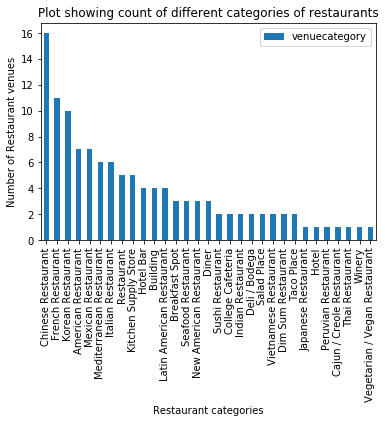

In [18]:
import matplotlib.pyplot as plt
categorydf=DowntownLA_restaurants['venuecategory'].value_counts().to_frame()

categorydf.plot(kind='bar')
plt.xlabel('Restaurant categories')
plt.ylabel('Number of Restaurant venues')
plt.title('Plot showing count of different categories of restaurants')
plt.show()

##### We see that major categories are Chinese,korean,French, Mexican and American. Various categories towards the lower end of graph can be grouped into miscelleneous category.

In [17]:
delivery_provider_data=DowntownLA_restaurants['deliveryoption'].value_counts().to_frame()
delivery_provider_data

,deliveryoption
No Delivery option,90
grubhub,30


#### Delivery Provider option distribution within Downtown Neighborhoods

In [19]:
df=DowntownLA_restaurants.groupby('Neighborhood')['deliveryoption'].value_counts().to_frame()
df

deliveryoption
Neighborhood deliveryoption                    
Chinatown    No Delivery option              23
             grubhub                          7
Downtown     No Delivery option              22
             grubhub                          8
Pico-Union   No Delivery option              22
             grubhub                          8
Westlake     No Delivery option              23
             grubhub                          7

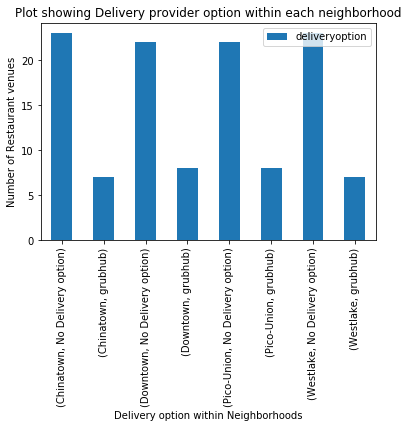

In [20]:
df.plot(kind='bar')
plt.xlabel('Delivery option within Neighborhoods')
plt.ylabel('Number of Restaurant venues')
plt.title('Plot showing Delivery provider option within each neighborhood')
plt.show()

##### We see that within all Neighborhoods most of the restaurants don't have a major delivery provider. 

### 3.1 Clustering of Restaurant Venues

Run K-Means to cluster all venues into 10 clusters based on Restaurant categories and delivery providers as X values.

In [21]:
# set number of clusters
kclusters = 10

category_clustering = restaurant_category.drop('Venueid', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(category_clustering)

# check cluster labels generated for each row in the dataframe
labels=kmeans.labels_
print(labels,len(labels))

[4 4 1 0 0 0 8 0 0 2 0 7 7 4 0 0 9 6 1 0 3 1 0 1 0 5 0 2 4 0 4 0 0 4 0 8 1
 2 0 1 6 6 4 4 6 3 0 4 1 7 0 0 9 1 1 0 5 0 0 1 0 0 5 1 8 0 1 5 5 4 4 0 0 7
 6 1 5 3 2 0 9 0 4 0 1 5 1 2 0 5 8 0 0 1 0 6 3 6 4 8 0 0 2 0 0 0 1 0 2 0 8
 0 7 1 4 0 0 5 9 1] 120


Merged Dataframe corresponding to every venue is obtained with additional column showing cluster label

In [22]:
DowntownLA_restaurants['labels']=labels
Restaurants_merged=DowntownLA_restaurants

print('Total restaurants:{}'.format(len(Restaurants_merged)))
Restaurants_merged.head() # sammple records

Total restaurants:120


,Neighborhood,Latitude,Longitude,Venueid,venuename,venueLatitude,venueLongitude,venuecategory,deliveryoption,labels
0,Chinatown,34.067573,-118.224722,49ebc74af964a5202b671fe3,Yang Chow Restaurant,34.062926,-118.238059,Chinese Restaurant,No Delivery option,4
1,Chinatown,34.067573,-118.224722,4415b1c5f964a520fd301fe3,Full House Seafood Restaurant,34.066155,-118.237916,Chinese Restaurant,No Delivery option,4
2,Chinatown,34.067573,-118.224722,52c77412498ee9acc1e90889,Liwan Restaurant & Hookah Lounge,34.050354,-118.437779,Mediterranean Restaurant,grubhub,1
3,Chinatown,34.067573,-118.224722,49c2818cf964a520f9551fe3,Boda Restaurant,34.075601,-118.217365,Vietnamese Restaurant,No Delivery option,0
4,Chinatown,34.067573,-118.224722,4aa8416bf964a5206c5020e3,Traxx Restaurant,34.056232,-118.236183,New American Restaurant,No Delivery option,0


Number of venues within each cluster 

In [ ]:
Restaurants_merged.groupby('labels').count()


#### Vizualization of cluster

In [23]:
address = 'Los Angeles Downtown, CA'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of los angeles City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of los angeles City are 34.4987133, -118.5843067.


In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=8)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, ven,venname, cluster in zip(Restaurants_merged['venueLatitude'], Restaurants_merged['venueLongitude'], Restaurants_merged['Neighborhood'],Restaurants_merged['Venueid'],Restaurants_merged['venuename'], Restaurants_merged['labels']):
    label = folium.Popup(str(venname) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 4. Results 

Below is the detailed examination of all 10 clusters

In [26]:


cluster0=Restaurants_merged[Restaurants_merged['labels']==0]
cluster1=Restaurants_merged[Restaurants_merged['labels']==1]
cluster2=Restaurants_merged[Restaurants_merged['labels']==2]
cluster3=Restaurants_merged[Restaurants_merged['labels']==3]
cluster4=Restaurants_merged[Restaurants_merged['labels']==4]
cluster5=Restaurants_merged[Restaurants_merged['labels']==5]
cluster6=Restaurants_merged[Restaurants_merged['labels']==6]
cluster7=Restaurants_merged[Restaurants_merged['labels']==7]
cluster8=Restaurants_merged[Restaurants_merged['labels']==8]
cluster9=Restaurants_merged[Restaurants_merged['labels']==9]



#### CLUSTER 0 - Based on below results it can be classified as miscelleneous restaurants with no delivery option

#### CLUSTER 1- Based on below results it can be classified as miscelleneous restaurants with grubhub as te major delivery provider

In [ ]:
cluster0

In [ ]:
cluster1

#### Cluster2 and cluster 4 -Based on results it can be classified as American Cuisine and New american cuisine restaurants with no delivery option

In [ ]:
cluster2

In [ ]:
cluster4

#### Cluster 3 corresponds to Mexican cuisine with no delivery option

In [ ]:
cluster3

#### Cluster 5 corresponds to Mediterranean cuisine with major delivery provider as grubhub

In [ ]:
cluster5

#### Cluster 6 corresponds to korean cuisine with no delivery option 

In [ ]:
cluster6

#### Cluster 7 corresponds to chinese cuisine with no major delivery provider

In [ ]:
cluster7

#### Cluster 8 corresponds to French restaurants with major delivery provider as grubhub

#### Cluster 9 corresponds to French restaurants with no major delivery provider.

In [ ]:
cluster8

In [ ]:
cluster9

### Pivot table to show count of Restaurant venues of different cuisines and their delivery option 

In [27]:

grp2 = Restaurants_merged.groupby(['venuecategory','deliveryoption'],as_index = False).count()
restaurantgrpd2=grp2[['venuecategory','deliveryoption','Venueid']]
restaurantgrpd2
pivottabdelivery=restaurantgrpd2.pivot(index = 'venuecategory' , columns = 'deliveryoption')
pivottabdelivery


Venueid        
deliveryoption                No Delivery option grubhub
venuecategory                                           
American Restaurant                          6.0     1.0
Breakfast Spot                               3.0     NaN
Building                                     4.0     NaN
Cajun / Creole Restaurant                    1.0     NaN
Chinese Restaurant                          14.0     2.0
College Cafeteria                            2.0     NaN
Deli / Bodega                                NaN     2.0
Dim Sum Restaurant                           2.0     NaN
Diner                                        NaN     3.0
French Restaurant                            4.0     7.0
Hotel                                        1.0     NaN
Hotel Bar                                    4.0     NaN
Indian Restaurant                            2.0     NaN
Italian Restaurant                           2.0     4.0
Japanese Restaurant                          1.0     NaN
Kitchen Supply Store                         5.0     NaN
Korean Restaurant                            9.0     1.0
Latin American Restaurant                    3.0     1.0
Mediterranean Restaurant                     2.0     4.0
Mexican Restaurant                           7.0     NaN
New American Restaurant                      3.0     NaN
Peruvian Restaurant                          1.0     NaN
Restaurant                                   1.0     4.0
Salad Place                                  2.0     NaN
Seafood Restaurant                           3.0     NaN
Sushi Restaurant                             2.0     NaN
Taco Place                                   1.0     1.0
Thai Restaurant                              1.0     NaN
Vegetarian / Vegan Restaurant                1.0     NaN
Vietnamese Restaurant                        2.0     NaN
Winery                                       1.0     NaN

### Heat Map to visualize the Pivot table

Text(0.5, 15.0, 'Delivery option')

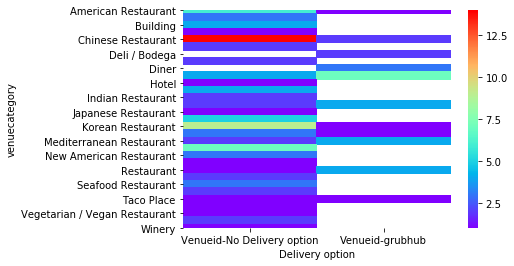

In [28]:

import seaborn as sns
sns.heatmap(pivottabdelivery,cmap='rainbow')
plt.xlabel('Delivery option')



## 5. Discussion

The clustering results can be summarized as follows :

cluster | Cuisines to be supported by Application| Delivery provider | success probability| 
--------|---------|------------------ |----------------------------------------------|
0|Miscellaneous|None|Moderate |
1|Miscellaneous|grubhub|Low |
2|American|None|High|
3|Mexican|None|High |
4|New American|None|High|
5|Mediterranean|grubhub|Low|
6|Korean|None|High|
7|Chinese|None|High|
8|French|grubhub|Low|
9|French|None|Moderate|


##### Bar Plots showing count  of different cuisines and their delivery provider Information.

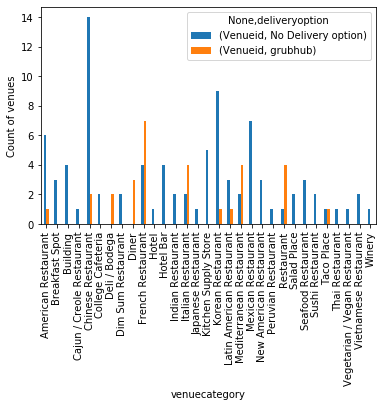

In [29]:
pivottabdelivery.plot(kind= 'bar')
plt.ylabel('Count of venues')
plt.show()

## 6. Conclusion

From the above analysis we can conclude that :

 1) For starting a new delivery provider service to current restaurants, Chinese,Korean,American and Mexican restaurants       will prove to be highly beneficial due to their large numbers and due to lack of any current major delivery provider       competetors.
    French Restaurants will be moderately beneficial as some french restaurants are already using grubhub service provider     and the rest may follow them too.
    Cluster 0 corresponding to miscelleneous cuisines may be profitable as they dont have current delivery provider but         might be challenging as multiple cuisines need to be supported.
    Cluster 1 restaurants will be least profitable as they have existing provider and also complex due to multiple             miscelleneous categories.
    
 2) From perspective of providing new cuisines/specialities in the location chinese/korean/French/Mexican/American may not be beneficial as they are already present in large numbers.Indian,Japanese,Peruvian,Viatnamese are in very few numbers.Starting these cuisines may be beneficial.